In [1]:

import os 
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from PIL import Image

import torch 
from torchvision import datasets, transforms, models 
from torchvision.models import * 
from torch.utils.data import DataLoader, Dataset 
from torch import nn 
import torchmetrics as tm 
from torchmetrics.classification import MulticlassConfusionMatrix

import pytorch_lightning as pl

from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore

RANDOM_SEED = 78 
np.random.seed(RANDOM_SEED) 
torch.manual_seed(RANDOM_SEED) 
torch.cuda.manual_seed(RANDOM_SEED) 
torch.cuda.manual_seed_all(RANDOM_SEED)

# Model

In [2]:
class EfficientNetB5Custom(nn.Module):
    def __init__(self, num_classes=5, pretrained=True):
        super(EfficientNetB5Custom, self).__init__()
        if pretrained:
            self.efficientnet = models.efficientnet_b5(weights=EfficientNet_B5_Weights.DEFAULT)
        else:
            self.efficientnet = models.efficientnet_b5(weights=None)
        self.name = "EfficientNetB5Custom"
        in_features = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        return self.efficientnet(x)

# Trainer

In [3]:
class Classification(pl.LightningModule):
    """
    Trainer para entrenar un modelo de clasificación multiclase
    y de dimension 1 con valores [0, num_classes]
    """
    def __init__(self, model, device, L1=0.001, L2=0.001, lr=0.001, patience=5, factor=0.1, betas=(0.9, 0.999)):
        super().__init__()
        self.save_hyperparameters(ignore=("model",))

        self.model = model

        self.loss_fn = nn.CrossEntropyLoss()
        self.L1 = L1
        self.L2 = L2
        self.learning_rate = lr
        self.patience = patience
        self.factor = factor
        self.betas = betas

        self.num_classes = 5
        self.confusion_matrix = MulticlassConfusionMatrix(num_classes=5).to(device)
        self.auc_metric = tm.AUROC(num_classes=5, task="multiclass").to(device)  # Definir métrica AUROC para clasificación multiclase

    def forward(self, x):
        return self.model(x)

    def training_step(self, x, y):
        y = y
        y_hat = self.model(x)
        y_oh = self.transform_classes(y)
        loss = self.loss_fn(y_hat, y_oh)
        
        # Regularización L1
        L1_reg = torch.tensor(0., requires_grad=True)
        for param in self.model.parameters():
            L1_reg = L1_reg + torch.sum(torch.abs(param))
        
        # Regularización L2
        L2_reg = torch.tensor(0., requires_grad=True)
        for param in self.model.parameters():
            L2_reg = L2_reg + torch.sum(param ** 2)
        
        # Añadir regularización a la pérdida
        loss = loss + self.L1 * L1_reg + self.L2 * L2_reg
        # Obtener la clase predicha
        y_pred = torch.argmax(y_hat, dim=1)
        # Calcular métricas
        loss.backward()
        self.confusion_matrix.update(y_pred, y)
        self.auc_metric.update(y_hat, y)

        precision, recall, f1_score, ACC, AUC, specificity = self.calculate_metrics_from_confusion_matrix()

        return {"loss": loss, "ACC": ACC, "recall": recall, "precision": precision, "f1_score": f1_score, "AUC": AUC, "specificity": specificity}

    def validation_step(self, x, y):
        y = y
        y_hat = self.model(x)
        y_oh = self.transform_classes(y)
        loss = self.loss_fn(y_hat, y_oh)
        # Obtener la clase predicha
        y_pred = torch.argmax(y_hat, dim=1)
        # Calcular métricas
        self.confusion_matrix.update(y_pred, y)
        self.auc_metric.update(y_hat, y)

        precision, recall, f1_score, ACC, AUC, specificity = self.calculate_metrics_from_confusion_matrix()
        return {"loss": loss, "ACC": ACC, "precision" : precision, "recall": recall, "f1_score" : f1_score, "AUC": AUC, "specificity": specificity}

    def transform_classes(self, y):
        # Convertir las clases a un formato de one-hot encoding
        return torch.nn.functional.one_hot(y.to(torch.int64), num_classes=5).to(float).squeeze()
    def restart_epoch(self, plot = False):
        if plot:
            self.plot()
        self.confusion_matrix.reset()
        self.auc_metric.reset()
    def calculate_metrics_from_confusion_matrix(self):
        # Obtener la matriz de confusión (suponiendo que es un tensor de torch)
        cm = self.confusion_matrix.compute()
        total_samples = cm.sum()
        
        # Verdaderos positivos por clase (diagonal de la matriz)
        true_positives = torch.diag(cm)
        
        # Predicciones totales por clase (sumar columnas)
        predicted_positives = cm.sum(dim=0)
        
        # Ejemplos reales por clase (sumar filas)
        actual_positives = cm.sum(dim=1)
        
        # Calcular falsos positivos y falsos negativos por clase
        false_positives = predicted_positives - true_positives
        false_negatives = actual_positives - true_positives
        
        # Calcular verdaderos negativos por clase
        true_negatives = total_samples - (actual_positives + predicted_positives - true_positives)
        
        # Calcular métricas por clase con robustez para evitar división por cero
        precision_per_class = true_positives / (predicted_positives + 1e-8)
        recall_per_class = true_positives / (actual_positives + 1e-8)
        specificity_per_class = true_negatives / (true_negatives + false_positives + 1e-8)
        f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class + 1e-8)
        
        # Promediar las métricas por clase
        precision = precision_per_class.mean()
        recall = recall_per_class.mean()
        specificity = specificity_per_class.mean()
        f1 = f1_per_class.mean()
        
        # Calcular Accuracy (exactitud)
        ACC = true_positives.sum() / total_samples
        
        # Calcular el AUC (suponiendo que self.auc_metric ya está correctamente definido)
        AUC = self.auc_metric.compute()
        
        return precision, recall, f1, ACC, AUC, specificity


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(),
                                     lr=self.learning_rate,
                                     betas=self.betas)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                               factor=self.factor,
                                                               patience=self.patience)
        return optimizer, scheduler

    def plot(self, epoch=0):
        # Computa la matriz de confusión y las métricas por clase
        cm = self.confusion_matrix.compute().cpu().numpy()
        support = cm.sum(axis=1)
        precision_per_class = np.diag(cm) / (cm.sum(axis=0) + 1e-8)
        recall_per_class = np.diag(cm) / (cm.sum(axis=1) + 1e-8)
        f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class + 1e-8)
        
        # Cálculo de especificidad por clase
        FP = cm.sum(axis=0) - np.diag(cm)
        FN = cm.sum(axis=1) - np.diag(cm)
        TN = cm.sum() - (FP + FN + np.diag(cm))
        specificity_per_class = TN / (TN + FP + 1e-8)
        
        accuracy = np.diag(cm).sum() / cm.sum()

        # Crea dos subplots: uno para la matriz de confusión y otro para la tabla de métricas
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))

        # Subplot 1: Matriz de confusión con heatmap
        sns.heatmap(cm, annot=True, fmt="d", ax=axs[0], cmap="Blues")
        axs[0].set_title("Matriz de Confusión epoch " + str(epoch))
        axs[0].set_xlabel("Predicción")
        axs[0].set_ylabel("Real")

        # Subplot 2: Tabla de métricas por clase
        table_data = []
        for i in range(self.num_classes):
            table_data.append([f"Clase {i}",
                            f"{precision_per_class[i]:.2f}",
                            f"{recall_per_class[i]:.2f}",
                            f"{f1_per_class[i]:.2f}",
                            f"{specificity_per_class[i]:.2f}",
                            int(support[i])])
        axs[1].axis('tight')
        axs[1].axis('off')
        table = axs[1].table(cellText=table_data,
                            colLabels=["Clase", "Precision", "Sensivity/Recall", "F1", "Specificity", "Support"],
                            cellLoc="center", loc="center")
        axs[1].set_title(f"Metrics por clase\nAccuracy General: {accuracy:.2f}", pad=20)


# Dataset

In [4]:
class OriginalOAIDataset(Dataset):
    def __init__(self, mode='train', batch_size=32, transform=None, local = False, path = ""):
        """
        Args:
            mode (str): 'train', 'val' o 'test'.
            transform: Transformaciones de torchvision a aplicar a las imágenes.
        """
        assert mode in ['train', 'val', 'test'], "Mode must be 'train', 'val', or 'test'"

        assert path != ""

        if local:
            print("LOCAL MODE ENABLED")
        self.transform = transform
        self.data_path = os.path.join(path, mode)
        self.classes = sorted(os.listdir(self.data_path))  # Lista de clases
        self.data = []
        self.batch_size = batch_size
        # Cargar imágenes con sus etiquetas
        

        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(self.data_path, class_name)
            i = 0
            for img_name in os.listdir(class_path):
                if local and i >= 3:
                    break
                img_path = os.path.join(class_path, img_name)
                self.data.append((img_path, label))
                i += 1
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        
        return image, label
    
    def get_dataloader(self, shuffle=True):       
        return DataLoader(self, batch_size=self.batch_size, shuffle=shuffle)



# Funcion Train

In [5]:
import torch
from tqdm import tqdm
from wandb import wandb

def create_tqdm_bar(iterable, desc, mode):
    return tqdm(enumerate(iterable),total=len(iterable), ncols=150, desc=desc)

def train_model(model, trainer, train_dataset, val_dataset, epochs=5, transform=None, device='cuda', name="Test", wdb=True, project="oai-knee-cartilage-segmentation", plot = 0):
    if wdb:
        if wandb.run is not None:
            wandb.finish()
        wandb.init(
            project="oai-knee-cartilage-sweep-AME11k",
            name="Sweep x",
            # track hyperparameters and run metadata
            config={
                "model": model.name,
                "Batch_size": train_dataset.batch_size,
                "learning_rate": trainer.learning_rate,
                "L1": trainer.L1,
                "L2": trainer.L2,
                "patience": trainer.patience,
                "factor": trainer.factor,
                "betas": trainer.betas,
                "epochs": epochs,
            },
            resume="allow"
        )
    train_loader = train_dataset.get_dataloader(shuffle=True)
    val_loader = val_dataset.get_dataloader(shuffle=True)
    model.to(device)
    train(model, train_loader, val_loader, trainer, epochs, device, wdb, plot = plot)
    

def train(model, train_loader, val_loader, trainer, epochs, device, wdb, plot = 0):
    """
    train the given model
    """
    optimizer, scheduler = trainer.configure_optimizers()
    
    for epoch in range(epochs):        
        training_loss = []
        validation_loss = []

        training_loss_num = 0
        validation_loss_num = 0

        # use training data
        model.train()

        training_loop = create_tqdm_bar(train_loader, desc=f'Training Epoch [{epoch + 1}/{epochs}]', mode='train')
        for train_iteration, batch in training_loop:
            batch = batch[0].to(device), batch[1].to(device)
            optimizer.zero_grad()
            res = trainer.training_step(batch[0], batch[1])
            optimizer.step()

            training_loss.append(res['loss'].item())
            training_loss_num += res['loss'].item()
            # Update the progress bar.
            training_loop.set_postfix(curr_train_loss="{:.8f}".format(training_loss_num / (train_iteration + 1)),
                                      acc=res['ACC'].item(),
                                      AUC=res['AUC'].item(),
                                      sensivity=res['recall'].item(),
                                      specificity=res['specificity'].item())
            if wdb:
                
                wandb.log({"train_loss": training_loss_num / (train_iteration + 1),
                        "train_acc": res['ACC'],
                        "train_recall": res['recall'].item(),
                        "train_precision": res['precision'].item(),
                        "train_specifity": res['specificity'].item(),
                        "train_f1_score": res['f1_score'].item(),
                        "train_AUC": res['AUC'],
                        "epoch": epoch})
        trainer.restart_epoch(plot=False)
        # use validation data
        model.eval()
        val_loop = create_tqdm_bar(val_loader, desc=f'Validation Epoch [{epoch + 1}/{epochs}]', mode='val')
        with torch.no_grad():
            for val_iteration, batch in val_loop:
                batch = batch[0].to(device), batch[1].to(device)
                res = trainer.validation_step(batch[0], batch[1])  
                validation_loss.append(res['loss'].item())
                validation_loss_num += res['loss'].item()
                val_loop.set_postfix(val_loss = "{:.8f}".format(validation_loss_num / (val_iteration + 1)),
                                      acc=res['ACC'].item(),
                                      AUC=res['AUC'].item(),
                                      specificity=res['specificity'].item())
                                      
        if wdb:
            wandb.log({"val_loss": validation_loss_num / (val_iteration + 1),
                    "val_acc": res['ACC'],
                    "val_recall": res['recall'].item(),
                    "val_precision": res['precision'].item(),
                    "val_specificity": res['specificity'].item(),
                    "val_f1_score": res['f1_score'].item(),
                    "val_AUC": res['AUC'],
                    "epoch": epoch})
        scheduler.step(res['loss'].item())
        if plot > 0 and epoch % plot == 0:
            trainer.plot(epoch=epoch)
        trainer.restart_epoch(plot=False)
    
    test_model(model, val_loader, trainer, device, wdb)

def test_model(model, test_loader, trainer, device, wdb=False):
    """
    Test the given model
    """
    model.eval()
    model.to(device)

    epoch_loss = 0.0
    avg_loss = 0.0
    trainer.restart_epoch(plot = False)
    for batch in test_loader:
        inputs, labels = batch
        inputs = inputs.to(device)
        
        labels = labels.to(device)

        with torch.no_grad():
            res = trainer.validation_step(inputs, labels)
            # Extraer valores escalares
            loss = res['loss']
            
        loss_value = loss.item()
        # Calcular promedios
        epoch_loss += loss_value

    ACC_value = res['ACC']
    recall_value = res['recall'].item()
    precision_value = res['precision'].item()
    f1_score_value = res['f1_score'].item()
    AUC_value = res['AUC']
    avg_loss = epoch_loss / len(test_loader)
    if wdb:
        wandb.log({"test_loss": avg_loss, "test_acc": ACC_value.item(),
                "test_recall": recall_value, "test_precision": precision_value,
                "test_f1_score": f1_score_value, "test_AUC" : AUC_value})
    
    print(f"Test model {model.__class__.__name__} - Loss: {avg_loss:.2f}, ACC: {ACC_value:.2f}, AUC: {AUC_value:.2f}, Sensivility: {recall_value:.2f}, Specificity: {precision_value:.2f}")

    trainer.restart_epoch(plot = True)

# Pre-Train

In [6]:
def train_sweep():
    wandb.init()
    config = wandb.config
    print(f"Configuración del Sweep: {config}")
    BATCH_SIZE = config.batch_size
    LEARNING_RATE = config.learning_rate
    FACTOR = 0.01
    PATIENCE = 5
    L1 = config.L1
    L2 = config.L2
    BETAS = (0.9,0.999)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    PATH = "/kaggle/input/augmented-mendeley-expert1-split/augmented_mendeley_expert1_split"
    train_dataset = OriginalOAIDataset('train', batch_size=BATCH_SIZE, transform=transform, local = False, path = PATH)
    val_dataset = OriginalOAIDataset('val', batch_size=256, transform=transform, local = False, path = PATH)
    
    model = EfficientNetB5Custom(num_classes = 5, pretrained = True)
    trainer = Classification(model, device, L1=L1, L2=L2, lr=LEARNING_RATE, factor=FACTOR, patience=PATIENCE, betas=BETAS)
    
    train_model(model, trainer, train_dataset, val_dataset, epochs=10, device=device, name="Sweep - Expert 1",wdb = True)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: chermar (chermar-universitat-polit-cnica-de-val-ncia). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Agent Starting Run: 5jk28fut with config:
wandb: 	L1: 0
wandb: 	L2: 0
wandb: 	batch_size: 40
wandb: 	learning_rate: 0.0001
wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250223_122344-5jk28fut
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run dandy-sweep-2
wandb: ⭐️ View project at https://wandb.ai/chermar-universitat-polit-cnica-de-val-ncia/oai-knee-cartilage-sweep-AME11k
wandb

Configuración del Sweep: {'L1': 0, 'L2': 0, 'batch_size': 40, 'learning_rate': 0.0001}


Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-1a07897c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b5_lukemelas-1a07897c.pth
100%|██████████| 117M/117M [00:00<00:00, 231MB/s]
wandb:                                                                                
wandb: 🚀 View run dandy-sweep-2 at: https://wandb.ai/chermar-universitat-polit-cnica-de-val-ncia/oai-knee-cartilage-sweep-AME11k/runs/5jk28fut
wandb: ⭐️ View project at: https://wandb.ai/chermar-universitat-polit-cnica-de-val-ncia/oai-knee-cartilage-sweep-AME11k
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250223_122344-5jk28fut/logs
wandb: WARNING Ignoring project 'oai-knee-cartilage-sweep-AME11k' when running a sweep.
wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250223_122350-5jk28fut
wandb: Run `wandb offline` to turn off syncing.
wandb: Resuming 

Test model EfficientNetB5Custom - Loss: 1.11, ACC: 0.80, AUC: 0.93, Sensivility: 0.79, Specificity: 0.80


wandb: uploading config.yaml; uploading output.log
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           epoch ▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇██
wandb:        test_AUC ▁
wandb:        test_acc ▁
wandb:   test_f1_score ▁
wandb:       test_loss ▁
wandb:  test_precision ▁
wandb:     test_recall ▁
wandb:       train_AUC ▁▄▅▇▇▇▇▇▇███████████████████████████████
wandb:       train_acc ▁▂▂▅▅▇▇▇▇▇▇▇▇▇▇█████████████████████████
wandb:  train_f1_score ▁▃▄▄▆▆▆▇▇▇▇▇▇▇▇█████████████████████████
wandb:      train_loss ███▇▇▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: train_precision ▂▁▁▂▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█▇▇▇██▇██████████████
wandb:    train_recall ▁▁▃▃▃▆▆▆▆▆▇▇▇▇▇▇▇██▇▇███████████████████
wandb: train_specifity ▁▁▃▃▃▄▄▆▆▆▆▇▇▇▇▇▇▇▇▇███▇▇███████████████
wandb:         val_AUC ▁▆▃▆█▇▄▅▇▇
wandb:         val_acc ▁▄▂▆▇▇▆▆▇█
wandb:    val_f1_score ▁▅▃▇▇▇▆▇▇█
wandb:        val_loss █▅▇▂▁▂▃▃▂▁
wandb:   val_precision ▁▄▂█▇▆▇▆▆█
wa

Configuración del Sweep: {'L1': 0.0001, 'L2': 0.0001, 'batch_size': 40, 'learning_rate': 0.001}


wandb:                                                                                
wandb: 🚀 View run woven-sweep-4 at: https://wandb.ai/chermar-universitat-polit-cnica-de-val-ncia/oai-knee-cartilage-sweep-AME11k/runs/ralo4r54
wandb: ⭐️ View project at: https://wandb.ai/chermar-universitat-polit-cnica-de-val-ncia/oai-knee-cartilage-sweep-AME11k
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250223_124110-ralo4r54/logs
wandb: WARNING Ignoring project 'oai-knee-cartilage-sweep-AME11k' when running a sweep.
wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250223_124114-ralo4r54
wandb: Run `wandb offline` to turn off syncing.
wandb: Resuming run Sweep x
wandb: ⭐️ View project at https://wandb.ai/chermar-universitat-polit-cnica-de-val-ncia/oai-knee-cartilage-sweep-AME11k
wandb: 🧹 View sweep at https://wandb.ai/chermar-universitat-polit-cnica-de-val-ncia/oa

Test model EfficientNetB5Custom - Loss: 1.59, ACC: 0.30, AUC: 0.74, Sensivility: 0.21, Specificity: 0.26


wandb: uploading config.yaml; uploading output.log
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           epoch ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇██
wandb:        test_AUC ▁
wandb:        test_acc ▁
wandb:   test_f1_score ▁
wandb:       test_loss ▁
wandb:  test_precision ▁
wandb:     test_recall ▁
wandb:       train_AUC ▁▁▁▁▂▄▄▅▆▄▅▅▄▅▆▆▆▆▆▆▆▆▆▆▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇
wandb:       train_acc ▁▂▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██▇▇███████████
wandb:  train_f1_score ▁▁▃▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇█▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇█▇██
wandb:      train_loss █▆▆▆▅▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: train_precision ▁▂▂▂▃▃▅▅▅▅▅▅▅▅▅▆▇▆▆▆▆▆▆█▇▇▇▇▆▆▆▆▆▇▇▇▇▇▇▇
wandb:    train_recall ▁▂▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█▇▇███▇▇██████████
wandb: train_specifity ▁▃▃▄▄▆▆▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇▇▇▇█████████
wandb:         val_AUC ▄▆▁▃▁▅▇▇▆█
wandb:         val_acc ▇▇▁▇▁▆█▁▇▇
wandb:    val_f1_score ▄▄▁▄▁▇█▃▄▅
wandb:        val_loss ▁▄█▃▆▄▁█▃▂
wandb:   val_precision ▂▂▁▂▁▃▄▂▂█
wa

Configuración del Sweep: {'L1': 0, 'L2': 0, 'batch_size': 40, 'learning_rate': 0.0001}


wandb:                                                                                
wandb: 🚀 View run desert-sweep-6 at: https://wandb.ai/chermar-universitat-polit-cnica-de-val-ncia/oai-knee-cartilage-sweep-AME11k/runs/ud6qybao
wandb: ⭐️ View project at: https://wandb.ai/chermar-universitat-polit-cnica-de-val-ncia/oai-knee-cartilage-sweep-AME11k
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250223_125809-ud6qybao/logs
wandb: WARNING Ignoring project 'oai-knee-cartilage-sweep-AME11k' when running a sweep.
wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250223_125814-ud6qybao
wandb: Run `wandb offline` to turn off syncing.
wandb: Resuming run Sweep x
wandb: ⭐️ View project at https://wandb.ai/chermar-universitat-polit-cnica-de-val-ncia/oai-knee-cartilage-sweep-AME11k
wandb: 🧹 View sweep at https://wandb.ai/chermar-universitat-polit-cnica-de-val-ncia/o

Test model EfficientNetB5Custom - Loss: 1.11, ACC: 0.79, AUC: 0.94, Sensivility: 0.76, Specificity: 0.79


wandb: uploading config.yaml; uploading output.log
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           epoch ▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▆▆▆▆▆▆▆▇▇▇██
wandb:        test_AUC ▁
wandb:        test_acc ▁
wandb:   test_f1_score ▁
wandb:       test_loss ▁
wandb:  test_precision ▁
wandb:     test_recall ▁
wandb:       train_AUC ▁▃▃▄▄▆▆▆▇▆▆▇▇█▇█████████████████████████
wandb:       train_acc ▁▂▂▃▃▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████████████
wandb:  train_f1_score ▁▂▃▃▃▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
wandb:      train_loss █▇▅▄▄▄▄▂▂▂▂▂▂▁▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: train_precision ▁▃▂▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
wandb:    train_recall ▁▁▂▂▂▃▃▃▃▅▅▇▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
wandb: train_specifity ▁▂▂▂▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
wandb:         val_AUC ▁▆▆▇▆▇▇█▇█
wandb:         val_acc ▁▇▇▇██▇▇██
wandb:    val_f1_score ▁▆▇▇██▇███
wandb:        val_loss █▂▂▂▁▁▂▁▁▁
wandb:   val_precision ▁▇▆▇▇█▇▇██
wa

Configuración del Sweep: {'L1': 0, 'L2': 0.0001, 'batch_size': 40, 'learning_rate': 0.001}


wandb:                                                                                
wandb: 🚀 View run faithful-sweep-8 at: https://wandb.ai/chermar-universitat-polit-cnica-de-val-ncia/oai-knee-cartilage-sweep-AME11k/runs/xdwxoxnm
wandb: ⭐️ View project at: https://wandb.ai/chermar-universitat-polit-cnica-de-val-ncia/oai-knee-cartilage-sweep-AME11k
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250223_131504-xdwxoxnm/logs
wandb: WARNING Ignoring project 'oai-knee-cartilage-sweep-AME11k' when running a sweep.
wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250223_131509-xdwxoxnm
wandb: Run `wandb offline` to turn off syncing.
wandb: Resuming run Sweep x
wandb: ⭐️ View project at https://wandb.ai/chermar-universitat-polit-cnica-de-val-ncia/oai-knee-cartilage-sweep-AME11k
wandb: 🧹 View sweep at https://wandb.ai/chermar-universitat-polit-cnica-de-val-ncia

Test model EfficientNetB5Custom - Loss: 1.32, ACC: 0.58, AUC: 0.84, Sensivility: 0.58, Specificity: 0.69


wandb: uploading config.yaml; uploading output.log
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           epoch ▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇█████
wandb:        test_AUC ▁
wandb:        test_acc ▁
wandb:   test_f1_score ▁
wandb:       test_loss ▁
wandb:  test_precision ▁
wandb:     test_recall ▁
wandb:       train_AUC ▁▁▁▁▁▁▂▂▂▁▁▁▂▁▁▄▄▄▄▃▄▂▃▄▄█▆▅▆▆▄▅▅▅▅▅▆▆▆▆
wandb:       train_acc ▁▄▅▄▅▅▅▅▅▅▅▅▅▆▆▆▆▅▅▆▆▆▆▇▇▇█▇▇▇██▇▇▇▇████
wandb:  train_f1_score ▁▃▄▄▄▄▃▄▄▄▄▄▄▄▄▅▅▅▅▅▄▅▅▆▆▅▅▅█▆▆▇▆▆▆▇▇▇▇▇
wandb:      train_loss █████▇▇▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
wandb: train_precision ▁▄▅▅▅▄▅▅▅▅▅▇▇▆▆▆▆▆▆▆▆▆█▇▇▇▇▇██▇▇▇▇▇█████
wandb:    train_recall ▁▄▄▄▅▄▅▄▆▆▆▆▆▇▅▅▆▆▆▇▇▇▇▇▇▇█▇▆▆▆██▇▇▇▇▇▇▇
wandb: train_specifity ▁▃▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▄▄▄▄▅▅▅▅▅▅▆▆▆█▅▅▆▆▆▆▆▆
wandb:         val_AUC ▁▂▅▇▅▅█▆▇▇
wandb:         val_acc ▁▃▄▅▁▇█▄▆▇
wandb:    val_f1_score ▁▁▃▄▁▆█▅▅█
wandb:        val_loss █▆▅▄▇▂▁▅▃▂
wandb:   val_precision ▁▃▃█▆▇▇▅▄▇
wa

Configuración del Sweep: {'L1': 0, 'L2': 0, 'batch_size': 20, 'learning_rate': 0.0005}


wandb:                                                                                
wandb: 🚀 View run scarlet-sweep-9 at: https://wandb.ai/chermar-universitat-polit-cnica-de-val-ncia/oai-knee-cartilage-sweep-AME11k/runs/i2t1ccs1
wandb: ⭐️ View project at: https://wandb.ai/chermar-universitat-polit-cnica-de-val-ncia/oai-knee-cartilage-sweep-AME11k
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250223_133209-i2t1ccs1/logs
wandb: WARNING Ignoring project 'oai-knee-cartilage-sweep-AME11k' when running a sweep.
wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250223_133214-i2t1ccs1
wandb: Run `wandb offline` to turn off syncing.
wandb: Resuming run Sweep x
wandb: ⭐️ View project at https://wandb.ai/chermar-universitat-polit-cnica-de-val-ncia/oai-knee-cartilage-sweep-AME11k
wandb: 🧹 View sweep at https://wandb.ai/chermar-universitat-polit-cnica-de-val-ncia/

Test model EfficientNetB5Custom - Loss: 1.35, ACC: 0.55, AUC: 0.80, Sensivility: 0.58, Specificity: 0.63


wandb: uploading wandb-summary.json; uploading output.log; uploading config.yaml
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           epoch ▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇███
wandb:        test_AUC ▁
wandb:        test_acc ▁
wandb:   test_f1_score ▁
wandb:       test_loss ▁
wandb:  test_precision ▁
wandb:     test_recall ▁
wandb:       train_AUC ▃▅▅▅▅▇▆▄▄▄▅▁▃▃▃▄▄▅▅▅▅▅▅▅▆▇▇▇▇▇▃▅▆▆▆▇▇███
wandb:       train_acc ▁▄▄▄█▅▅▅▅▅▄▄▄▄▂▅▅▅▅▅▃▃▄▄▄▅▄▅▅▆▆▆▆▆▅▆▇▇▇▆
wandb:  train_f1_score ▄▅█▆▆▆▆▅▅▅▄▅▅▅▆▅▁▁▄▄▃▄▄▅▅▅▇▇▇▇▇▇▇▇▆▇████
wandb:      train_loss █▆▅▅▅▅▅▅▅▃▃▄▅▅▅▅▄▄▄▄▅▆▆▆▆▄▄▄▄▄▃▂▂▂▂▅▃▃▂▁
wandb: train_precision ▃▂▂▃▃▃▃▃█▄▄▄▄▄▄▃▃▃▃▄▂▁▁▃▃▄▄▄▃▄▄▄▆▆▃▅▅█▇▇
wandb:    train_recall ▂▂▇▅▆▅▄▄▃▃▂▂▃▃▃▃▃▃▃▃▁▂▃▃▃▄▄▄▇▆▇▅▅▅▅█▇▇██
wandb: train_specifity ▄▄▇▆▅▄▄▄▄▅▅▅▅▅▂▂▁▃▄▄▄▅▂▃▄▄▄▅▅▅▇▇▇▇▇▇▄▄▆█
wandb:         val_AUC ▇▁▃▂▄▄█▄█▇
wandb:         val_acc ▇▁▂▁▄▄█▅█▇
wandb:    val_f1_score ▇▂▁▂▃▄▇▅█▇
wandb:        val_loss ▂█▇█▅▅▁▄▁▂
wandb:

Configuración del Sweep: {'L1': 0, 'L2': 0, 'batch_size': 30, 'learning_rate': 0.001}


wandb:                                                                                
wandb: 🚀 View run zesty-sweep-11 at: https://wandb.ai/chermar-universitat-polit-cnica-de-val-ncia/oai-knee-cartilage-sweep-AME11k/runs/q1mcz7zo
wandb: ⭐️ View project at: https://wandb.ai/chermar-universitat-polit-cnica-de-val-ncia/oai-knee-cartilage-sweep-AME11k
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250223_135217-q1mcz7zo/logs
wandb: WARNING Ignoring project 'oai-knee-cartilage-sweep-AME11k' when running a sweep.
wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250223_135221-q1mcz7zo
wandb: Run `wandb offline` to turn off syncing.
wandb: Resuming run Sweep x
wandb: ⭐️ View project at https://wandb.ai/chermar-universitat-polit-cnica-de-val-ncia/oai-knee-cartilage-sweep-AME11k
wandb: 🧹 View sweep at https://wandb.ai/chermar-universitat-polit-cnica-de-val-ncia/o

Test model EfficientNetB5Custom - Loss: 1.64, ACC: 0.24, AUC: 0.59, Sensivility: 0.28, Specificity: 0.14


wandb: uploading wandb-summary.json; uploading config.yaml; uploading output.log
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           epoch ▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
wandb:        test_AUC ▁
wandb:        test_acc ▁
wandb:   test_f1_score ▁
wandb:       test_loss ▁
wandb:  test_precision ▁
wandb:     test_recall ▁
wandb:       train_AUC ▁▄▆▅▅▄▄▄▄▆▅▅▅▅▄▅▅█▆▇▇▇▇▅▅▃▃▃▃▄▆▆▆▆▆▇▇▆▇▆
wandb:       train_acc ▁▆▅▅▅▅▅▅▄▄▄▄▄▄▄▅▆▆██▇▇▇▄▅▄▄▃▃▄▄▅▆▆▆▆▆▆▆▅
wandb:  train_f1_score ▄▄▄▃▁▁▂▂▂▂▂▂▂▃▃▅▅▅▅▆██▇▆▇▇▇▇▃▃▃▁▁▄▄▅▅▅▅▅
wandb:      train_loss █▅▅▄▄▅▆▅▆▆▄▅▅▄▄▁▁▁▂▂▄▃▃▃▃▃▃▆▆▅▇▇▇▇▄▄▄▄▄▄
wandb: train_precision ▃▄▅▄▄▄▄▄▃▃▃▃▃▃▃▂▄▄███▇▇▆▆▆▆▆▅▅▅▁▁▁▁▄▅▅▅▅
wandb:    train_recall ▁▄▅▅▃▄▄▃▃▃▅▄▅██▇▇▇▇▇▆▆▆▆▄▄▅▅▅▄▅▅▅▅▄▅▅▅▅▅
wandb: train_specifity ▄▄▄▄▄▃▃▇▄▃▂▃▃▅█▇▆▇▇▆▂▃▄▄▁▁▄▄▄▄▅▃▄▅▄▅▅▅▅▄
wandb:         val_AUC ▂▅▃█▆▃▃▁▇▃
wandb:         val_acc ▁▅▅█▆▇▅▄▄▂
wandb:    val_f1_score ▁▄▄█▇▅▄▃▅▁
wandb:        val_loss █▄▄▁▃▂▄▅▅▆
wandb:

Configuración del Sweep: {'L1': 0.0001, 'L2': 0, 'batch_size': 40, 'learning_rate': 0.001}


wandb: uploading config.yaml; uploading output.log
wandb:                                                                                
wandb: 🚀 View run royal-sweep-13 at: https://wandb.ai/chermar-universitat-polit-cnica-de-val-ncia/oai-knee-cartilage-sweep-AME11k/runs/kt1z082o
wandb: ⭐️ View project at: https://wandb.ai/chermar-universitat-polit-cnica-de-val-ncia/oai-knee-cartilage-sweep-AME11k
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250223_141014-kt1z082o/logs
wandb: WARNING Ignoring project 'oai-knee-cartilage-sweep-AME11k' when running a sweep.
wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250223_141019-kt1z082o
wandb: Run `wandb offline` to turn off syncing.
wandb: Resuming run Sweep x
wandb: ⭐️ View project at https://wandb.ai/chermar-universitat-polit-cnica-de-val-ncia/oai-knee-cartilage-sweep-AME11k
wandb: 🧹 View sweep at https://wan

Test model EfficientNetB5Custom - Loss: 1.46, ACC: 0.44, AUC: 0.76, Sensivility: 0.49, Specificity: 0.50


wandb: uploading config.yaml; uploading output.log
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           epoch ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
wandb:        test_AUC ▁
wandb:        test_acc ▁
wandb:   test_f1_score ▁
wandb:       test_loss ▁
wandb:  test_precision ▁
wandb:     test_recall ▁
wandb:       train_AUC ▁▄▄▄▄▄▄▅▆▆▇▆▆▆▆▇▇▇▇█▇▇▇▇▇█▇▇▇▇██████████
wandb:       train_acc ▁▃▃▄▄▄▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇███
wandb:  train_f1_score ▁▁▂▂▁▃▃▄▄▄▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇▇██████▇██
wandb:      train_loss █▇▆▆▅▅▅▄▄▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: train_precision ▁▁▁▁▃▃▃▅▅▅▆▆▆▆▇▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████
wandb:    train_recall ▁▁▃▃▃▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▆▇▇▇▆▇▇▇▇▇█▇▇▇██
wandb: train_specifity ▁▁▁▃▃▃▅▅▇▆▆▆▆▆▆▆▆▇▇▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████
wandb:         val_AUC ▄▁▁▄▆▅██▆▇
wandb:         val_acc ▁▁▁▂▃▄▆▅▇█
wandb:    val_f1_score ▁▁▁▂▄▄▄▇▆█
wandb:        val_loss ▇██▇▆▆▃▃▂▁
wandb:   val_precision ▁▁▁▄▅▆▅▆▆█
wa

Configuración del Sweep: {'L1': 0.0001, 'L2': 0, 'batch_size': 30, 'learning_rate': 0.0005}


wandb:                                                                                
wandb: 🚀 View run charmed-sweep-15 at: https://wandb.ai/chermar-universitat-polit-cnica-de-val-ncia/oai-knee-cartilage-sweep-AME11k/runs/eqa46pas
wandb: ⭐️ View project at: https://wandb.ai/chermar-universitat-polit-cnica-de-val-ncia/oai-knee-cartilage-sweep-AME11k
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250223_142730-eqa46pas/logs
wandb: WARNING Ignoring project 'oai-knee-cartilage-sweep-AME11k' when running a sweep.
wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250223_142734-eqa46pas
wandb: Run `wandb offline` to turn off syncing.
wandb: Resuming run Sweep x
wandb: ⭐️ View project at https://wandb.ai/chermar-universitat-polit-cnica-de-val-ncia/oai-knee-cartilage-sweep-AME11k
wandb: 🧹 View sweep at https://wandb.ai/chermar-universitat-polit-cnica-de-val-ncia

Test model EfficientNetB5Custom - Loss: 1.25, ACC: 0.66, AUC: 0.88, Sensivility: 0.60, Specificity: 0.69


wandb: uploading wandb-summary.json; uploading config.yaml; uploading output.log
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           epoch ▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█████
wandb:        test_AUC ▁
wandb:        test_acc ▁
wandb:   test_f1_score ▁
wandb:       test_loss ▁
wandb:  test_precision ▁
wandb:     test_recall ▁
wandb:       train_AUC ▁▅▅▅▆▆▇▇▇▇▇▇▇▇▇█▇▇█▇▇▇▇▇████████████████
wandb:       train_acc ▁▂▃▃▄▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇
wandb:  train_f1_score ▁▂▂▂▄▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█▇▇▇▇▇▇▇█▇███
wandb:      train_loss █▇▇▇▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: train_precision ▁▂▂▂▂▂▂▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████
wandb:    train_recall ▁▁▂▃▄▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
wandb: train_specifity ▁▃▄▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇█▇████████
wandb:         val_AUC ▄▁▃▆██▅▆█▇
wandb:         val_acc ▁▁▁▃▆█▄███
wandb:    val_f1_score ▁▁▁▄▇█▅▇██
wandb:        val_loss ███▅▃▁▅▁▁▁
wandb:

Configuración del Sweep: {'L1': 0.0001, 'L2': 0.0001, 'batch_size': 40, 'learning_rate': 0.0005}


wandb:                                                                                
wandb: 🚀 View run pious-sweep-17 at: https://wandb.ai/chermar-universitat-polit-cnica-de-val-ncia/oai-knee-cartilage-sweep-AME11k/runs/pbsxa0ly
wandb: ⭐️ View project at: https://wandb.ai/chermar-universitat-polit-cnica-de-val-ncia/oai-knee-cartilage-sweep-AME11k
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250223_144531-pbsxa0ly/logs
wandb: WARNING Ignoring project 'oai-knee-cartilage-sweep-AME11k' when running a sweep.
wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250223_144535-pbsxa0ly
wandb: Run `wandb offline` to turn off syncing.
wandb: Resuming run Sweep x
wandb: ⭐️ View project at https://wandb.ai/chermar-universitat-polit-cnica-de-val-ncia/oai-knee-cartilage-sweep-AME11k
wandb: 🧹 View sweep at https://wandb.ai/chermar-universitat-polit-cnica-de-val-ncia/o

Test model EfficientNetB5Custom - Loss: 1.32, ACC: 0.56, AUC: 0.89, Sensivility: 0.58, Specificity: 0.73


wandb: uploading config.yaml; uploading output.log
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           epoch ▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇█████
wandb:        test_AUC ▁
wandb:        test_acc ▁
wandb:   test_f1_score ▁
wandb:       test_loss ▁
wandb:  test_precision ▁
wandb:     test_recall ▁
wandb:       train_AUC ▁▁▂▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇██▇▇▇▇▇▇▇▇███
wandb:       train_acc ▁▂▃▃▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇█▇▇▇▇███▇▇▇▇█▇▇▇▇██
wandb:  train_f1_score ▁▁▂▂▃▃▄▄▄▆▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█▇▇▇▇▇█████
wandb:      train_loss ██▇▇▇▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: train_precision ▁▁▃▂▂▃▃▄▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇▇█▇█████
wandb:    train_recall ▁▁▁▁▂▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████
wandb: train_specifity ▁▁▂▂▃▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███▇▇▇████████████
wandb:         val_AUC ▁▃▂▂▄▃▄▁▅█
wandb:         val_acc ▁▃▃▁▁▁▂▃▆█
wandb:    val_f1_score ▁▂▂▁▂▁▂▄▅█
wandb:        val_loss ▆▆▆▇▇█▇▆▃▁
wandb:   val_precision ▁▁▁▁▅▁▂▆▆█
wa

Configuración del Sweep: {'L1': 0, 'L2': 0, 'batch_size': 20, 'learning_rate': 0.001}


wandb:                                                                                
wandb: 🚀 View run royal-sweep-19 at: https://wandb.ai/chermar-universitat-polit-cnica-de-val-ncia/oai-knee-cartilage-sweep-AME11k/runs/c1a9n20g
wandb: ⭐️ View project at: https://wandb.ai/chermar-universitat-polit-cnica-de-val-ncia/oai-knee-cartilage-sweep-AME11k
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250223_150235-c1a9n20g/logs
wandb: WARNING Ignoring project 'oai-knee-cartilage-sweep-AME11k' when running a sweep.
wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250223_150239-c1a9n20g
wandb: Run `wandb offline` to turn off syncing.
wandb: Resuming run Sweep x
wandb: ⭐️ View project at https://wandb.ai/chermar-universitat-polit-cnica-de-val-ncia/oai-knee-cartilage-sweep-AME11k
wandb: 🧹 View sweep at https://wandb.ai/chermar-universitat-polit-cnica-de-val-ncia/o

Test model EfficientNetB5Custom - Loss: 1.41, ACC: 0.48, AUC: 0.76, Sensivility: 0.42, Specificity: 0.51


wandb: uploading config.yaml; uploading output.log
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           epoch ▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
wandb:        test_AUC ▁
wandb:        test_acc ▁
wandb:   test_f1_score ▁
wandb:       test_loss ▁
wandb:  test_precision ▁
wandb:     test_recall ▁
wandb:       train_AUC ▁▅▄▄▅▇▇█▇▇▅▅▃▂▂▄▃▃▃▃▂▂▂▂▂▄▄▆██▇▇███▅▇▆▆▆
wandb:       train_acc ▅▄▄▄▆▇▇▇▇▇▆▆▆▆▇▃▂▂▁▃▄▃▃▃▂▂▂▃▃▄▄▅▅▆▇███▇▆
wandb:  train_f1_score ▁▅▅▅▆▇█▇▇▆▅▅▅▄▅▅▅▅▅▂▃▃▄▄▄▅▅▅▆▆▇▇█▇▇▇▇▇▇▇
wandb:      train_loss █▄▄▄▄▄▄▄▄▂▁▁▁▁▃▁▆▆▅▅▆▅▅▅▅▅▅▄▄▄▃▂▂▁▁▂▂▂▂▂
wandb: train_precision ▁▄▄▄▆▇███▇▇▇▇▇▇▆▆▆▄▅▄▄▄▆▆▄▄▄▄▄▆█▇██▇▇▇▇▇
wandb:    train_recall ▁▄▅▄▄▇▇▇▆▆▆▆▃▂▂▂▄▃▃▃▂▂▂▂▂▂▃▃▅▅▇▇▇▇▇███▆▆
wandb: train_specifity ▂▄▄▅▄▇▇▇▇▇▆▆▆▆▅▅▃▂▂▂▃▃▁▂▂▂▂▃▃▃▇████▇▆▆▆▆
wandb:         val_AUC ▁▅▄▆▁▂▆█▅█
wandb:         val_acc ▅▁▃▅▂▄▃▅▃█
wandb:    val_f1_score ▄▃▁▃▁▃▄▆▅█
wandb:        val_loss ▅▇▇▄█▆▆▃▇▁
wandb:   val_precision ▃▂▂▃▁▃▃▅▃█
wa

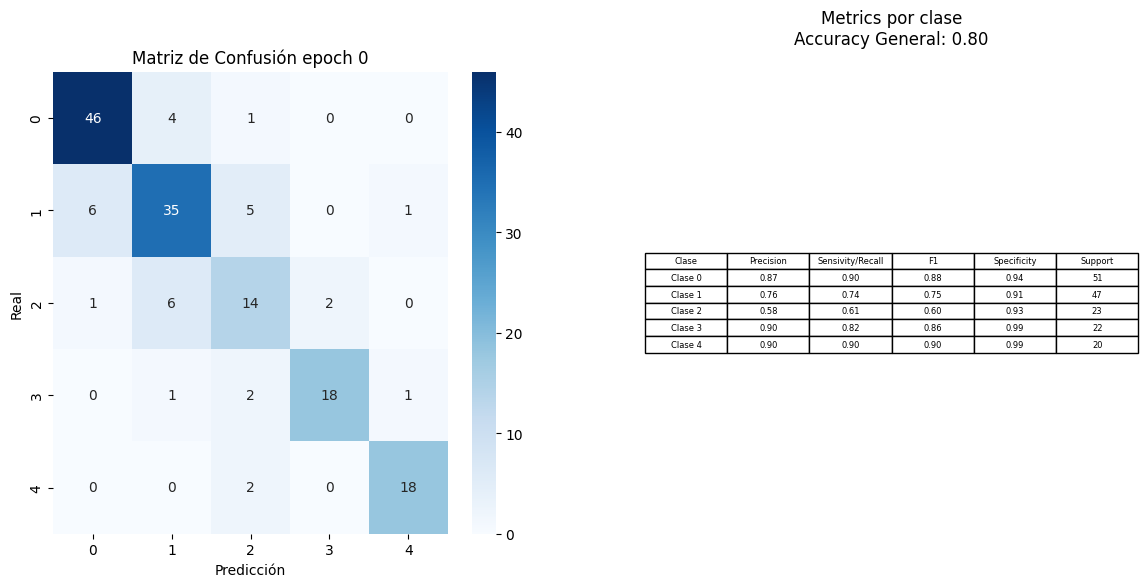

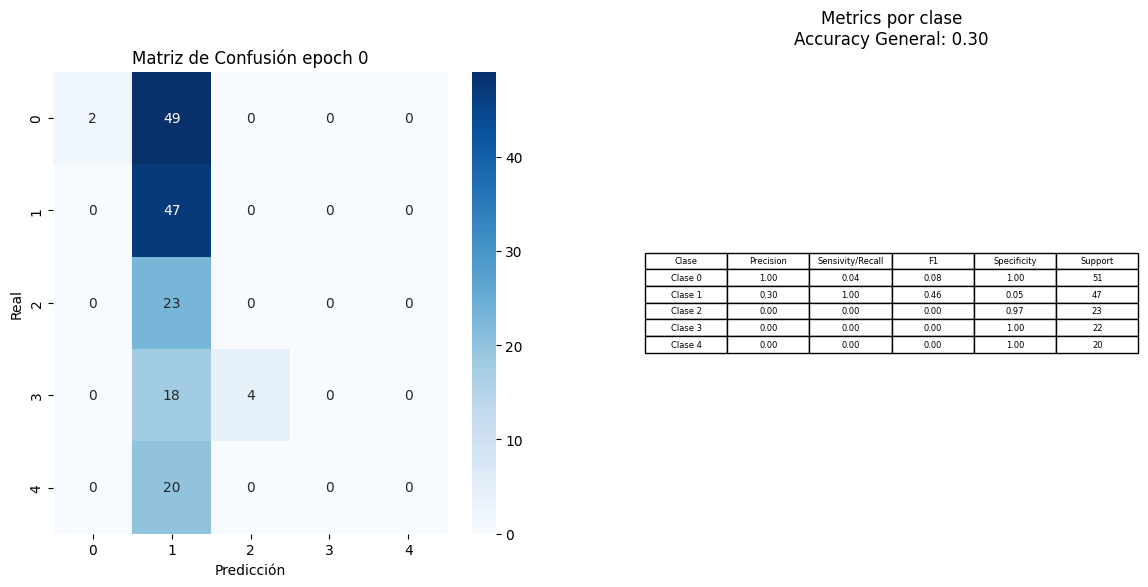

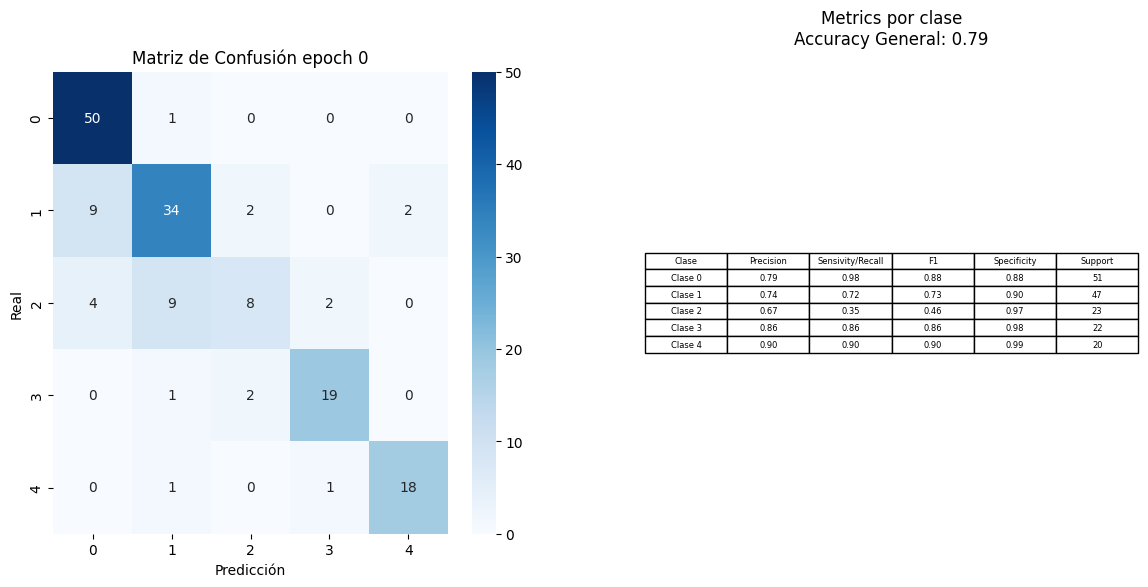

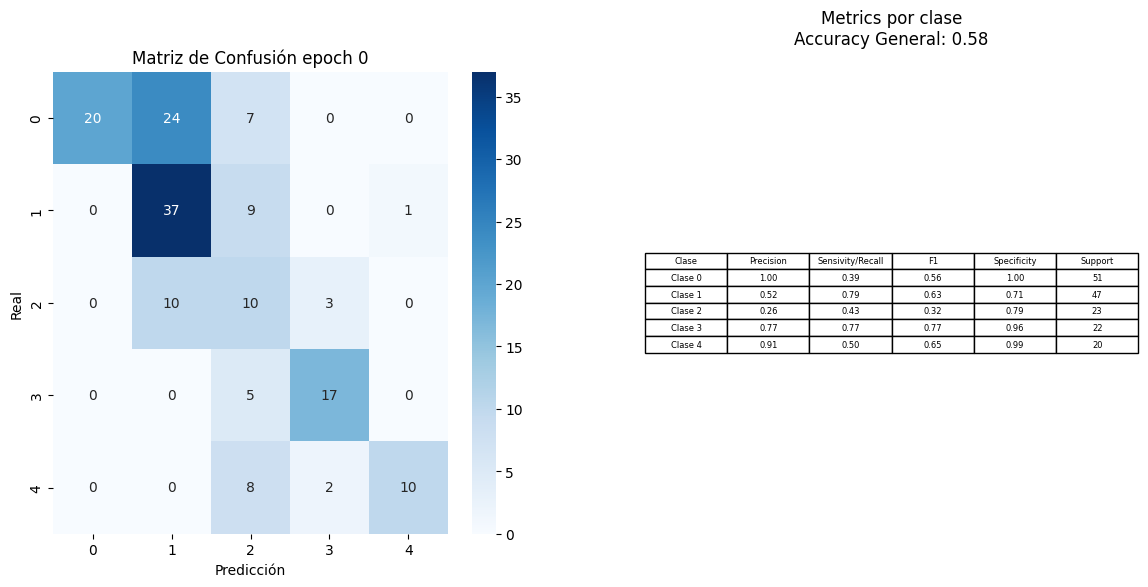

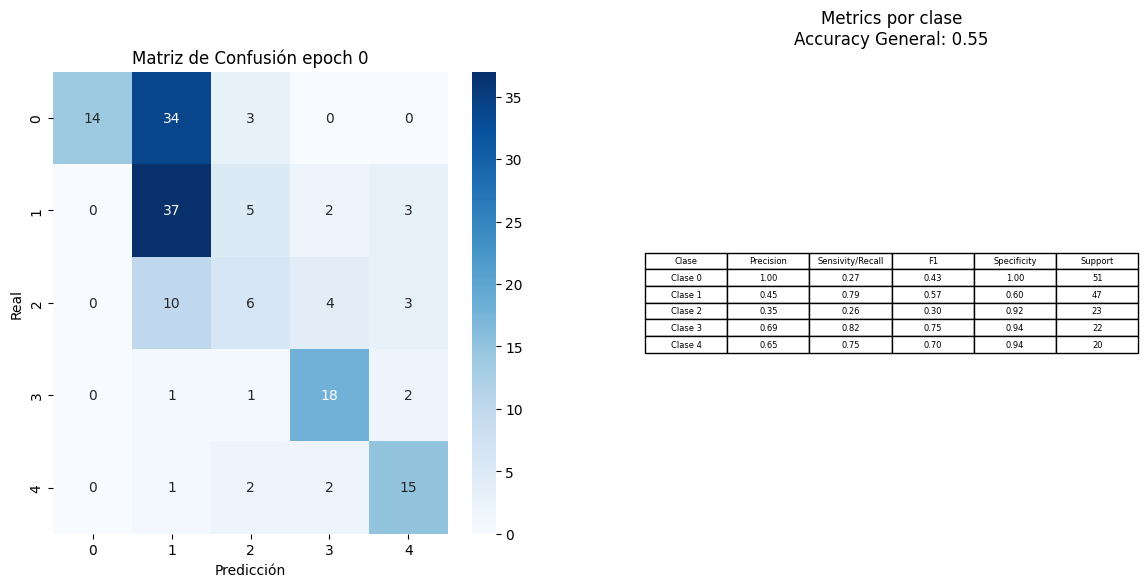

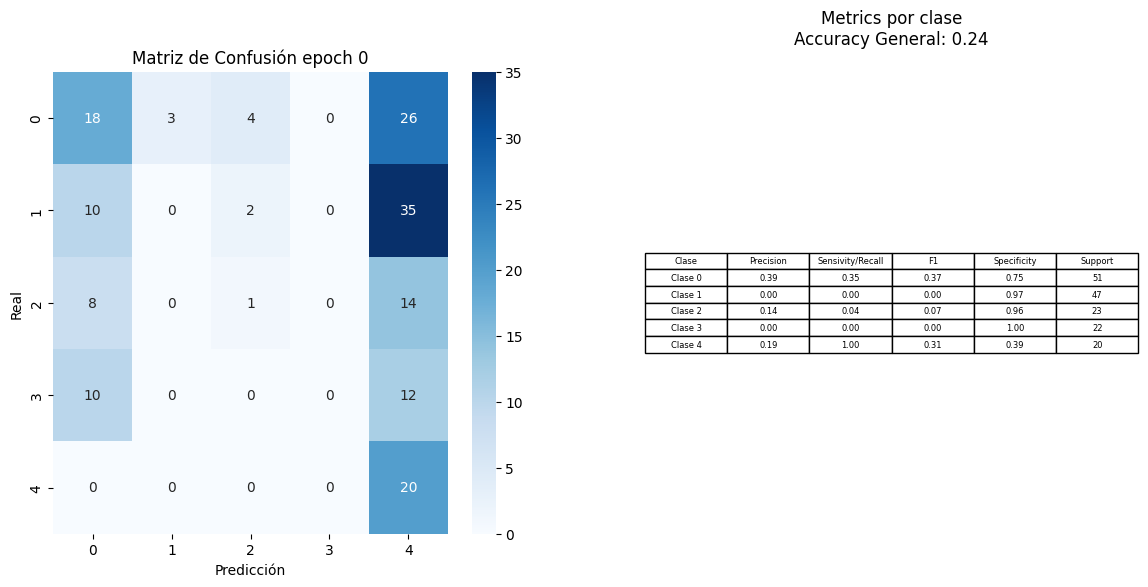

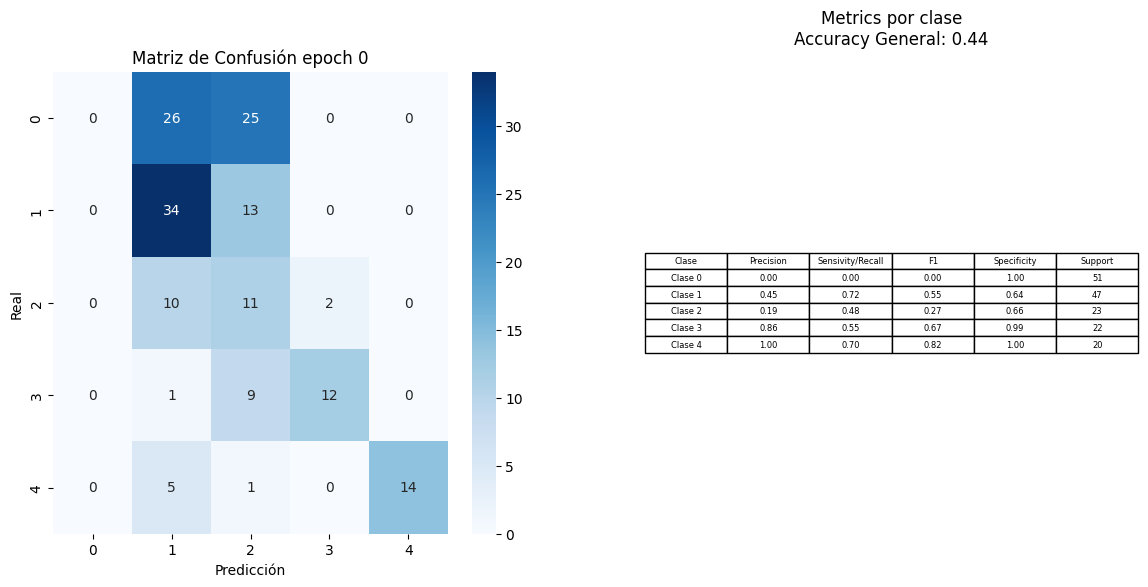

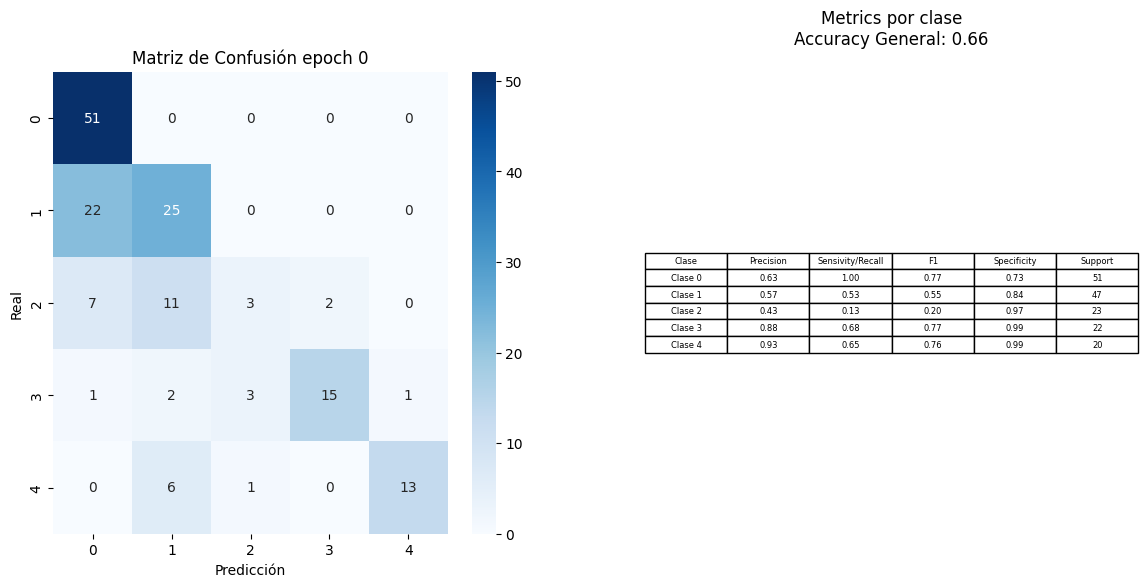

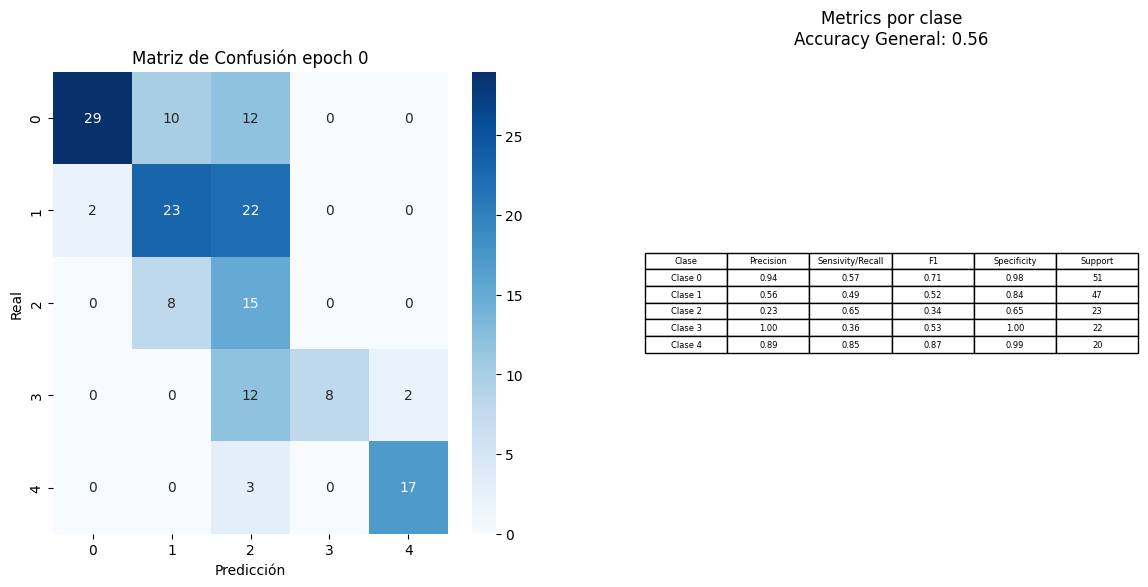

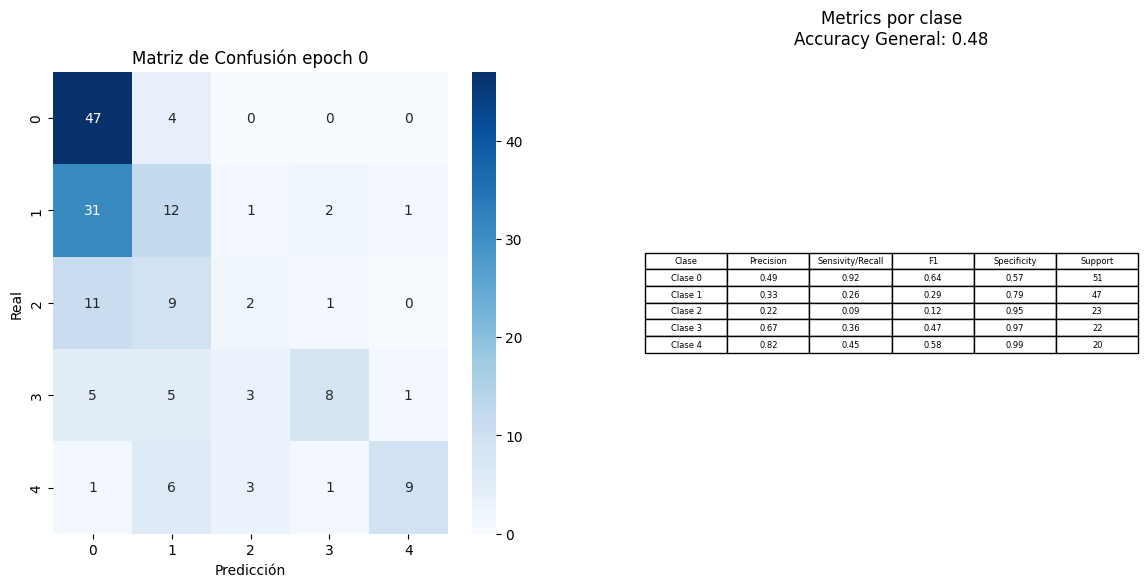

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
BATCH_SIZE = 20
LEARNING_RATE = 0.001
FACTOR = 0.001
L1 = 0.0001
L2 = 0.0001
PATIENCE = 5
BETAS=(0.9, 0.999)
# Regularización L1 y L2
wandb.login(key="254f72e7bdeec44797ba1b2a91ebbc63900b89f4")
sweep_config = {
    "method": "random",  # Opciones: "grid", "random", "bayes"
    "metric": {"name": "test_loss", "goal": "minimize"},  # Objetivo
    "parameters": {
        "learning_rate": {"values": [0.001, 0.0001, 0.0005]},
        "batch_size": {"values": [20, 30, 40]},
        "L1": { "values": [0, 0.0001]},
        "L2": { "values": [0, 0.0001]},
    }
}

wandb.agent("fpmm6lof", train_sweep, project="oai-knee-cartilage-sweep-AME11k", count=10)  # count es el número de ejecuciones

# Train